In [86]:
import os
import sys
import pandas as pd
import numpy as np
import argparse
import dlib
import cv2
import imutils
import matplotlib.pyplot as plt


class Face_affine():
    def __init__(self, image_path=None,path_model='../models/shape_predictor_68_face_landmarks.dat'):
        self.detector = dlib.get_frontal_face_detector()
        self.predictor = dlib.shape_predictor(path_model)
        self.face_classifier = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
        # self.image = cv2.imread(image_path)
        self.image = image_path
        # self.image = imutils.resize(self.image, width=500)
        self.gray = None
    
    def update_image(self,image_path):
        self.image = image_path
        self.gray = cv2.cvtColor(self.image, cv2.COLOR_BGR2GRAY)
    
    def rect_to_bb(self,rect):
        x = rect.left()
        y = rect.top()
        w = rect.right() - x
        h = rect.bottom() - y
        return (x, y, w, h)

    def shape_to_np(self, shape, dtype="int"):
        coords = np.zeros((68, 2), dtype=dtype)
        for i in range(0, 68):
            coords[i] = (shape.part(i).x, shape.part(i).y)
        return coords
    
    def get_rects2(self):
        """_summary_
        Detect face in image using dlib detector
        Returns:
            rects (_type_): list of bounding box of the face detected
        """
        rects = self.detector(self.gray, 1)
        rects = [(rect.left(), rect.top(), 
                  rect.right()-rect.left(), 
                  rect.bottom()-rect.top()) for rect in rects]
        
        return rects
    
    def get_rects(self):
        """_summary_
        Detect face in image using opencv detector
        Returns:
            rects (_type_): list of bounding box of the face detected
        """
        # detect faces in the grayscale image
        # rects = self.detector(self.gray, 1)
        rects = self.face_classifier.detectMultiScale(self.gray, scaleFactor=1.1, minNeighbors=9, minSize=(64, 64))
        return rects
    
    def get_shapes(self,rects):
        shapes = []
        for (i, rect) in enumerate(rects):
            # print(rect)
            rect = dlib.rectangle(rect[0], rect[1], rect[0]+rect[2], rect[1]+rect[3])
            shape = self.predictor(self.gray, rect)
            shape = self.shape_to_np(shape)
            shapes.append(shape)
        return shapes
    
    def get_face(self,shape):
        (x, y, w, h) = cv2.boundingRect(shape)
        roi = self.image[y:y+h, x:x+w]
        return roi
    
    def get_face2(self,image,rect):
        (x, y, w, h) = rect
        roi = image[y:y+h, x:x+w]
        return roi
    
    def get_shape_drop(self,image,shape,rect):
        (x, y, w, h) =  rect
        shape_drop = shape - np.array([x,y])
        image_drop = image[y:y+h, x:x+w]
        return image_drop, shape_drop
    
    
    
    def rotating_scaling(self,image,shape, rect):
        """_summary_
        Align face using dlib shape predictor
        Image will be rotated and scaled to align the face to the center of the image
        I use the eye center as the reference point to align the face.
        Args:
            image (_type_): image to be aligned
            shape (_type_): shape of the face detected, using dlib shape predictor, 68 landmarks
            rect (_type_): bounding box of the face detected

        Returns:
            image (_type_): aligned image
            rect (_type_): bounding box of the face detected after alignment
        """
        desiredFaceWidth, desiredFaceHeight= image.shape[1], image.shape[0]
        # compute the center of mass for each eye
        leftEyeCenter = shape[36:42].mean(axis=0).astype("int")
        rightEyeCenter = shape[42:48].mean(axis=0).astype("int")
        # compute the angle between the eye centroids
        dY = rightEyeCenter[1] - leftEyeCenter[1]
        dX = rightEyeCenter[0] - leftEyeCenter[0]
        angle = np.degrees(np.arctan2(dY, dX)) 
        # compute the desired right eye x-coordinate based on the desired x-coordinate of the left eye
        desiredLeftEye=(0.35, 0.35)
        desiredRightEyeX = 1.0 - desiredLeftEye[0]
        dist = np.sqrt((dX ** 2) + (dY ** 2)) # distance between the eyes
        desiredDist = (desiredRightEyeX - desiredLeftEye[0]) * desiredFaceWidth # desired distance between the eyes
        scale = desiredDist / dist
        # compute center (x, y)-coordinates 
        # between the two eyes in the input image
        eyesCenter = ((leftEyeCenter[0] + rightEyeCenter[0]) / 2, (leftEyeCenter[1] + rightEyeCenter[1]) / 2)
        # grab the rotation matrix for rotating and scaling the face
        M = cv2.getRotationMatrix2D(eyesCenter, angle, scale)
        # update the translation component of the matrix
        tX = desiredFaceWidth * 0.5
        tY = desiredFaceHeight * desiredLeftEye[1]
        M[0, 2] += (tX - eyesCenter[0])
        M[1, 2] += (tY - eyesCenter[1])
        # apply the affine transformation
        (w, h) = (desiredFaceWidth, desiredFaceHeight)
        output = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC)
        # return the aligned face
        output = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)
        # draw bounding box react of face detection after alignment
        (x, y, w, h) = rect
        x = int(x/scale)
        y = int(y/scale)
        w = int(w*scale)
        h = int(h*scale)
        # cv2.rectangle(output, (x, y), (x + w, y + h), (0, 255, 0), 2)
        
        return output, (x, y, w, h)
    
    def drop_padding_black(self,image):
        """_summary_
        Drop padding black from image
        Args:
            image (_type_): image to be processed

        Returns:
            crop (_type_): image dropped padding black
        """
        # drop padding black
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        _, thresh = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnt = contours[0]
        x, y, w, h = cv2.boundingRect(cnt)
        crop = image[y:y+h, x:x+w]
        return crop
    
    def drop_all_black(self,image):
        # drop padding black
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        _, thresh = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnt = contours[0]
        print(cnt[0][0][0], cnt[0][0][1])
        cv2.drawContours(image, contours[0], -1, (0,255,0), 3)
        cv2.circle(image, (cnt[0][0][0], cnt[0][0][1]), 5, (0,0,255), -1)
        # drop padding all countour
        a = []
        x, y, w, h = cv2.boundingRect(cnt)
        crop = image[y:y+h, x:x+w]
        return crop

In [87]:
face = Face_affine()
face.update_image(cv2.imread('./data/4-yeu-cau-cua-ky-nang-noi-truoc-dam-dong.jpg'))
rects = face.get_rects2()
print(rects)

[(468, 96, 129, 129), (842, 216, 90, 89), (253, 67, 129, 129)]


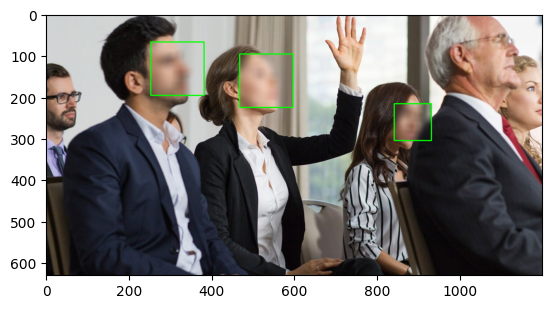

In [88]:
def blur_face(image, rect, favor=0.5):
    (x, y, w, h) = rect
    roi = image[y:y+h, x:x+w]
    roi = cv2.GaussianBlur(roi, (23, 23), 30)
    image[y:y+roi.shape[0], x:x+roi.shape[1]] = roi
    return image

def blur_faces(image, rects):
    for rect in rects:
        image = blur_face(image, rect)
        cv2.rectangle(image, (rect[0], rect[1]), (rect[0]+rect[2], rect[1]+rect[3]), (0, 255, 0), 2)
    return image

image = blur_faces(cv2.cvtColor(face.image, cv2.COLOR_BGR2RGB), rects)
plt.imshow(image)